<a href="https://colab.research.google.com/github/binliu0630/transformers/blob/master/STS_interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/semantic-similarity-using-transformers-8f3cb5bf66d6


https://towardsdatascience.com/interpreting-semantic-text-similarity-from-transformer-models-ba1b08e6566c

# Install libraries required

In [2]:
!pip install transformers hdbscan pacmap

     |████████████████████████████████| 2.3MB 5.1MB/s 
     |████████████████████████████████| 3.3MB 22.8MB/s 
     |████████████████████████████████| 901kB 34.3MB/s 


# Download dataset

In [ ]:
!wget https://s3-us-west-2.amazonaws.com/ai2-website/data/ARC-V1-Feb2018.zip

In [ ]:
from zipfile import ZipFile

with ZipFile('ARC-V1-Feb2018.zip', "r") as zip_obj:
    zip_obj.extractall("data")    

# Import dataset into Pandas

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("./data/ARC-V1-Feb2018-2/ARC-Easy/ARC-Easy-Train.csv")

# Load transformer model

In [3]:
from transformers import pipeline
feature_extraction = pipeline('feature-extraction', model="distilroberta-base", tokenizer="distilroberta-base")


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
features = feature_extraction("i amsentence")

In [14]:
import numpy as np
from transformers import AutoTokenizer, AutoModel, pipeline


model = AutoModel.from_pretrained('distilbert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
nlp = pipeline('feature-extraction', model=model, tokenizer=tokenizer)

features = nlp('Do you like cookies ?')
print(features)
features = np.squeeze(features)
print(features.shape)
# (7, 768)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



[[[-0.09632865339517593, -0.052850302308797836, -0.022886190563440323, -0.09755348414182663, -0.00798530038446188, -0.2632831633090973, 0.03672304376959801, 0.501137912273407, -0.2910234034061432, -0.15326569974422455, 0.211557999253273, -0.1701526939868927, -0.1832878440618515, 0.2057831585407257, -0.05425066873431206, 0.06256579607725143, -0.019160067662596703, 0.2986120283603668, 0.02297154627740383, 0.003973204642534256, -0.02410067431628704, -0.20894388854503632, -0.040224574506282806, -0.040700774639844894, -0.08085818588733673, -0.07856667786836624, 0.15791268646717072, -0.07217413187026978, 0.2641969621181488, -0.06252199411392212, 0.12513259053230286, 0.19970881938934326, -0.17517702281475067, -0.1268942952156067, 0.11396736651659012, 0.22916936874389648, 0.08676175773143768, -0.12258884310722351, -0.07108567655086517, 0.0339498445391655, -0.3423280119895935, 0.055934540927410126, -0.030394090339541435, 0.12068111449480057, 0.034662242978811264, -0.211740642786026, -2.1146464

In [15]:
print(features)

[[-0.09632865 -0.0528503  -0.02288619 ... -0.11329263  0.30909997
   0.27796322]
 [ 0.5927695  -0.13714762 -0.39261684 ... -0.18494107  0.71325916
  -0.2806803 ]
 [ 0.00884809 -0.36477345  0.32701775 ...  0.11720812  0.36718038
  -0.43832871]
 ...
 [ 0.2904675   0.25181669 -0.15239717 ... -0.12343983 -0.03957215
  -0.10586184]
 [ 0.06891873 -0.55227941 -0.60962296 ... -0.34572139  0.26402438
   0.02018064]
 [ 0.80382216  0.19779927 -0.35422871 ...  0.18203448 -0.33749092
  -0.40857163]]


In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from itertools import zip_longest
import torch


def grouper(iterable, n, fillvalue=None):
    """Taken from: https://docs.python.org/3/library/itertools.html#itertools-recipes"""
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)


def mean_pooling(model_output, attention_mask):
    """
    Mean pooling to get sentence embeddings. See:
    https://huggingface.co/sentence-transformers/paraphrase-distilroberta-base-v1
    """
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1) # Sum columns
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


# Sentences to embed
df = df[df.question.str.contains('\?')]
df.question = [s.split('?')[0] + '?' for s in df.question]

# Fetch the model & tokenizer from transformers library
model_name = 'sentence-transformers/stsb-roberta-large'
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create sentence embeddings

In [ ]:
sentence_embeddings = []
token_embeddings = []

# Embed 8 sentences at a time
for sentences in tqdm(grouper(df.question.tolist(), 8, None)):
    
    # Ignore sentences with None
    valid_sentences = [s for s in sentences if s]

    # Tokenize input
    encoded_input = tokenizer(valid_sentences, padding=True, truncation=True, max_length=512, return_tensors="pt")    

    # Create word embeddings
    model_output = model(**encoded_input)

    # For each sentence, store a list of token embeddings; i.e. a 1024-dimensional vector for each token
    for i, sentence in enumerate(valid_sentences):
        tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][i])
        embeddings = model_output[0][i]
        token_embeddings.append(
            [{"token": token, "embedding": embedding.detach().numpy()} for token, embedding in zip(tokens, embeddings)]
        )    

    # Pool to get sentence embeddings; i.e. generate one 1024 vector for the entire sentence
    sentence_embeddings.append(
        mean_pooling(model_output, encoded_input['attention_mask']).detach().numpy()
    )
    
# Concatenate all of the embeddings into one numpy array of shape (n_sentences, 1024)
sentence_embeddings = np.concatenate(sentence_embeddings)

223it [09:57,  2.68s/it]


# Perform Search & Show Search Context

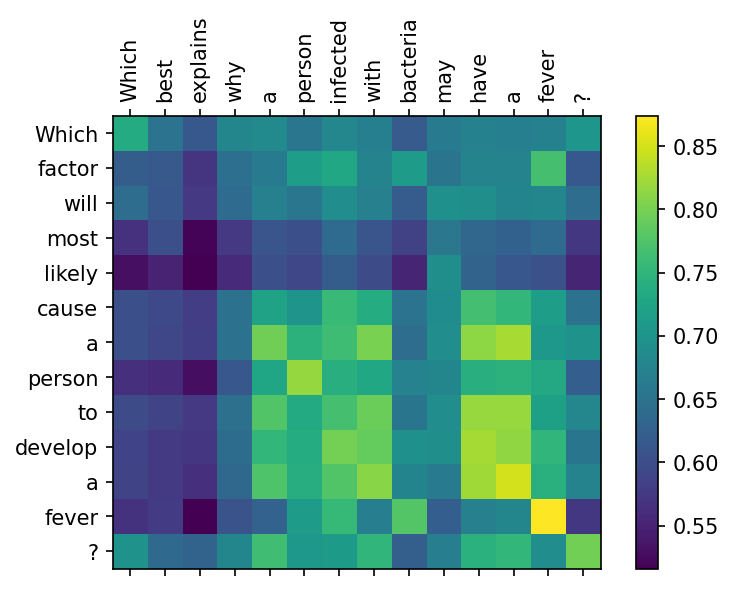

In [ ]:
from IPython.core.display import display, HTML
from sklearn.preprocessing import normalize
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# Noralize the data
norm_data = normalize(sentence_embeddings, norm='l2')

# Set QUERY & BEST MATCH IDs
QUERY_ID = 0
scores = np.dot(norm_data, norm_data[QUERY_ID].T)
MATCH_ID = np.argsort(scores)[-2]


def get_token_embeddings(embeddings_word):
    """Returns a list of tokens and list of embeddings"""
    tokens, embeddings = [], []
    for word in embeddings_word:
        if word['token'] not in ['<s>', '<pad>', '</pad>', '</s>']:
            tokens.append(word['token'].replace('Ġ', ''))
            embeddings.append(word['embedding'])    
    return tokens, normalize(embeddings, norm='l2')

# Get tokens & token embeddings
query_tokens, query_token_embeddings = get_token_embeddings(token_embeddings[QUERY_ID])
match_tokens, match_token_embeddings = get_token_embeddings(token_embeddings[MATCH_ID])

# Calculate cosine similarity between all tokens in query and match sentences
attention = (query_token_embeddings @ match_token_embeddings.T)

def plot_attention(src, trg, attention):
    """Plot 2D plot of cosine similarities"""
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(111)
    cax = ax.matshow(attention, interpolation='nearest')
    clb = fig.colorbar(cax)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xticklabels([''] + src, rotation=90)
    ax.set_yticklabels([''] + trg) 
    

plot_attention(match_tokens, query_tokens, attention)

In [ ]:
lengths_query

array([31.789795, 31.70999 , 31.7887  , 31.811132, 31.831669, 31.8176  ,
       31.872398, 31.823124, 31.841738, 31.825384, 31.84016 , 31.65322 ,
       31.862818], dtype=float32)

In [ ]:
attention.shape

(13, 14)